1. retrieve 
2. generate
3. rewrite <- 신규 노드
4. 문서 검증 <- 신규 노드 

In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)
retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [2]:
from langgraph.graph import StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

노드 만들기

In [3]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

프롬프트가 rewrite 등 여러군데에서 쓰이므로 이름 별도 지정 

In [5]:
from langchain_classic import hub

generate_prompt = hub.pull("rlm/rag-prompt")

In [6]:
def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'question':query, 'context': context})
    return {'answer': response}

문서의 관련성을 측정하는 노드 만들기 

In [7]:
from langchain_classic import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query']
    context = state['context']
    print(f'context == {context}')
    doc_relevance_chain = doc_relevance_prompt | llm
    response =  doc_relevance_chain.invoke({'question':query, 'documents': context})
    print(f'doc relevance reponse: {response}')
    if response['Score'] == 1:
        return 'generate'
    return 'rewrite'

rewrite 작성하기 

In [8]:
query = '연봉 5천만원 직장인의 소득세는?'

In [9]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전 : {dictionary}
질문 : {query}
""")
 
def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    reponse = rewrite_chain.invoke({'query': query})
    return {'query' : reponse}

In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

엣지 추가하기 

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [12]:
graph = graph_builder.compile()

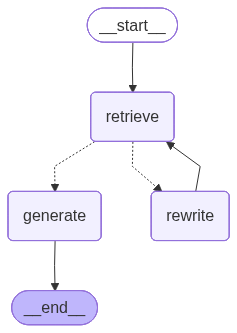

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

context == [Document(id='3d54c6c3-b56d-46ed-bba3-23cde26607b1', metadata={'source': './documents/income_tax.txt'}, page_content='③ 제4항에도 불구하고 2024년 1월 1일부터 2024년 12월 31일까지 지급한 기부금을 해당 과세기간의 합산과세대 상 종합소득산출세액(필요경비에 산입한 기부금이 있는 경우 사업소득에 대한 산출세액은 제외한다)에서 공제하는 경우에는 같은 항에 따른 세액공제액 외에 같은 항 각 호의 기부금을 합한 금액에서 사업소득금액을 계산할 때 필 요경비에 산입한 기부금을 뺀 금액이 3천만원을 초과하는 경우 그 초과분에 대해서는 100분의 10에 해당하는 금액 을 추가로 공제한다.<신설 2021. 12. 8., 2022. 12. 31., 2023. 12. 31.>\n⑤ 거주자가 다음 각 호의 어느 하나에 해당하는 경우 다. 각 호의 구분에 따른 금액을 종합소득산출세액에서 공 제하여야 하는 경우\n(제이) "표준세액공제"라 한다<개정 2020. 12. 29., 2025. 12. 23.>\n\n근로소득이 있는 거주자로서 제6항, 제52조제8항 및 「조세특례제한법」 제95조제3호제3항에 따른 소득공제나 세액 공제 신청을 하지 아니한 경우: 연 13만원\n종합소득이 있는 거주자(근로소득이 있는 자는 제외한다)로서 「조세특례제한법」 제122조제3호에 따른 세액공제 신청을 하지 아니한 경우: 다음 각 목의 구분에 따른 금액\n가. 제16조제5항제3항에 따른 사용료계좌의 신고 등 대통령령으로 정하는 요건에 해당하는 사업자(이하 “성실사 업자”라 한다)의 경우: 연 12만원'), Document(id='9b8ed712-bce1-48f6-bbab-b6885721a901', metadata={'source': './documents/income_tax.txt'}, page_content='근속연수에 따라 정한 다음의 금액\n\n| 근속연수 | 공제액 |\n| --

{'query': '연봉 5천만원 거주자의 소득세는?',
 'context': [Document(id='3d54c6c3-b56d-46ed-bba3-23cde26607b1', metadata={'source': './documents/income_tax.txt'}, page_content='③ 제4항에도 불구하고 2024년 1월 1일부터 2024년 12월 31일까지 지급한 기부금을 해당 과세기간의 합산과세대 상 종합소득산출세액(필요경비에 산입한 기부금이 있는 경우 사업소득에 대한 산출세액은 제외한다)에서 공제하는 경우에는 같은 항에 따른 세액공제액 외에 같은 항 각 호의 기부금을 합한 금액에서 사업소득금액을 계산할 때 필 요경비에 산입한 기부금을 뺀 금액이 3천만원을 초과하는 경우 그 초과분에 대해서는 100분의 10에 해당하는 금액 을 추가로 공제한다.<신설 2021. 12. 8., 2022. 12. 31., 2023. 12. 31.>\n⑤ 거주자가 다음 각 호의 어느 하나에 해당하는 경우 다. 각 호의 구분에 따른 금액을 종합소득산출세액에서 공 제하여야 하는 경우\n(제이) "표준세액공제"라 한다<개정 2020. 12. 29., 2025. 12. 23.>\n\n근로소득이 있는 거주자로서 제6항, 제52조제8항 및 「조세특례제한법」 제95조제3호제3항에 따른 소득공제나 세액 공제 신청을 하지 아니한 경우: 연 13만원\n종합소득이 있는 거주자(근로소득이 있는 자는 제외한다)로서 「조세특례제한법」 제122조제3호에 따른 세액공제 신청을 하지 아니한 경우: 다음 각 목의 구분에 따른 금액\n가. 제16조제5항제3항에 따른 사용료계좌의 신고 등 대통령령으로 정하는 요건에 해당하는 사업자(이하 “성실사 업자”라 한다)의 경우: 연 12만원'),
  Document(id='90acc4bf-9e2f-467e-87cb-83dc3935f2bc', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제